In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
kmader_rsna_bone_age_path = kagglehub.dataset_download('kmader/rsna-bone-age')

print('Data source import complete.')

100%|██████████| 9.29G/9.29G [01:43<00:00, 95.9MB/s]

Extracting files...


Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os
from PIL import Image
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Setting random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)


TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Training data shape: (12611, 3)
Training data columns: ['id', 'boneage', 'male']
     id  boneage   male
0  1377      180  False
1  1378       12  False
2  1379       94  False
3  1380      120   True
4  1381       82  False

Dataset Statistics:
Number of samples: 12611
Bone age range: 1 - 228 months
Mean bone age: 127.32 months
Gender distribution:
male
True     6833
False    5778
Name: count, dtype: int64


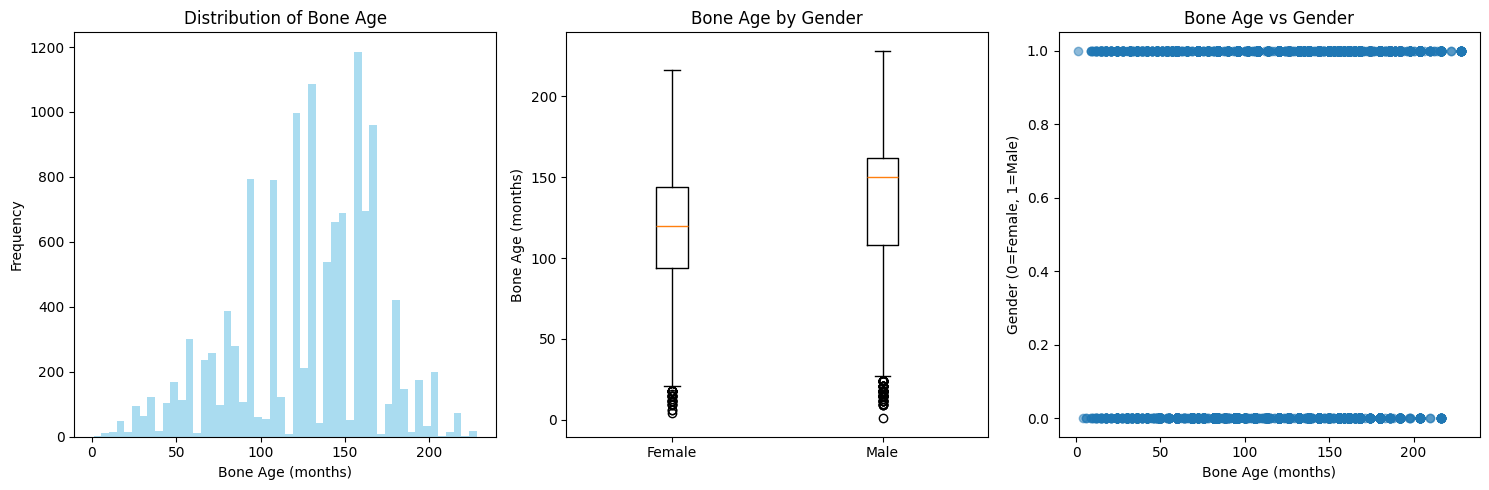

In [ ]:
# Load training data
train_df = pd.read_csv(f'{kmader_rsna_bone_age_path}/boneage-training-dataset.csv')
print(f"Training data shape: {train_df.shape}")
print(f"Training data columns: {train_df.columns.tolist()}")
print(train_df.head())

# Data exploration
print("\nDataset Statistics:")
print(f"Number of samples: {len(train_df)}")
print(f"Bone age range: {train_df['boneage'].min()} - {train_df['boneage'].max()} months")
print(f"Mean bone age: {train_df['boneage'].mean():.2f} months")
print(f"Gender distribution:\n{train_df['male'].value_counts()}")

# Plot bone age distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(train_df['boneage'], bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Bone Age (months)')
plt.ylabel('Frequency')
plt.title('Distribution of Bone Age')

plt.subplot(1, 3, 2)
plt.boxplot([train_df[train_df['male']==0]['boneage'],
             train_df[train_df['male']==1]['boneage']],
            labels=['Female', 'Male'])
plt.ylabel('Bone Age (months)')
plt.title('Bone Age by Gender')

plt.subplot(1, 3, 3)
plt.scatter(train_df['boneage'], train_df['male'], alpha=0.5)
plt.xlabel('Bone Age (months)')
plt.ylabel('Gender (0=Female, 1=Male)')
plt.title('Bone Age vs Gender')

plt.tight_layout()
plt.show()


In [ ]:
import os

def explore_directory(path, max_depth=3, current_depth=0):
    """Explore directory structure to find image files"""
    items = []
    if current_depth >= max_depth:
        return items

    try:
        for item in os.listdir(path):
            item_path = os.path.join(path, item)
            if os.path.isdir(item_path):
                print("  " * current_depth + f"📁 {item}/")
                items.extend(explore_directory(item_path, max_depth, current_depth + 1))
            elif item.endswith(('.png', '.jpg', '.jpeg')):
                items.append(item_path)
                if len(items) <= 5:  # Show first 5 images as examples
                    print("  " * current_depth + f"🖼️ {item}")
    except PermissionError:
        print("  " * current_depth + "❌ Permission denied")

    return items

print("Exploring dataset directory structure:")
image_files = explore_directory(kmader_rsna_bone_age_path)
print(f"\nFound {len(image_files)} image files total")

# Let's also check what's directly in the training dataset directory
training_path = f'{kmader_rsna_bone_age_path}/boneage-training-dataset'
print(f"\nContents of {training_path}:")
if os.path.exists(training_path):
    for item in os.listdir(training_path):
        item_path = os.path.join(training_path, item)
        if os.path.isdir(item_path):
            print(f"📁 {item}/ (contains {len(os.listdir(item_path))} items)")
        else:
            print(f"📄 {item}")


Exploring dataset directory structure:
📁 boneage-test-dataset/
  📁 boneage-test-dataset/
    🖼️ 4392.png
    🖼️ 4437.png
    🖼️ 4513.png
    🖼️ 4488.png
    🖼️ 4444.png
📁 boneage-training-dataset/
  📁 boneage-training-dataset/
    🖼️ 12635.png
    🖼️ 10010.png
    🖼️ 6663.png
    🖼️ 1818.png
    🖼️ 4247.png

Found 12811 image files total

Contents of /root/.cache/kagglehub/datasets/kmader/rsna-bone-age/versions/2/boneage-training-dataset:
📁 boneage-training-dataset/ (contains 12611 items)



LOADING DATASET WITH CORRECTED PATHS
Using sample of 5000 images
Loading 5000 images...
Processed 500/5000 images - Success: 500, Failed: 0
Processed 1000/5000 images - Success: 1000, Failed: 0
Processed 1500/5000 images - Success: 1500, Failed: 0
Processed 2000/5000 images - Success: 2000, Failed: 0
Processed 2500/5000 images - Success: 2500, Failed: 0
Processed 3000/5000 images - Success: 3000, Failed: 0
Processed 3500/5000 images - Success: 3500, Failed: 0
Processed 4000/5000 images - Success: 4000, Failed: 0
Processed 4500/5000 images - Success: 4500, Failed: 0
Processed 5000/5000 images - Success: 5000, Failed: 0
Successfully loaded 5000 images

Final training data shape: X=(5000, 224, 224, 1), y=(5000,)
Success rate: 5000/5000 (100.0%)


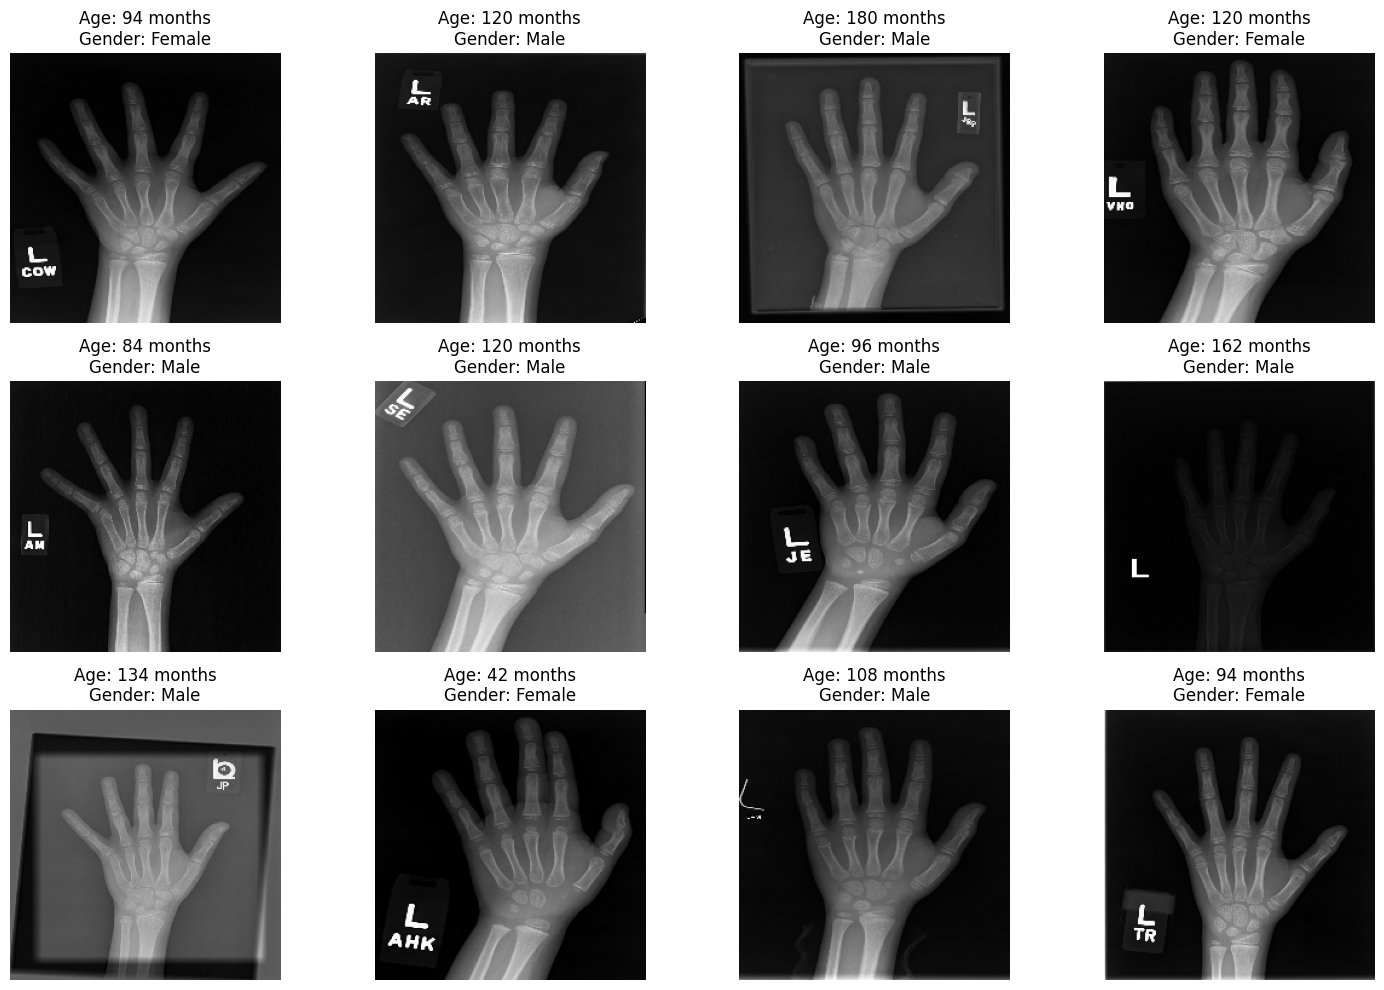

In [ ]:
def preprocess_image(img_path, target_size=(224, 224)):
    """
    Load and preprocess a single image
    """
    try:
        # Read image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            return None

        # Resize image
        img = cv2.resize(img, target_size)

        # Normalize pixel values to [0, 1]
        img = img.astype(np.float32) / 255.0

        # Add channel dimension for grayscale
        img = np.expand_dims(img, axis=-1)

        return img
    except Exception as e:
        return None

def find_correct_image_path(base_dir, image_id):
    """
    Finding the correct path for an image by searching through subdirectories
    """
    # Common patterns for image paths in RSNA datasets
    possible_paths = [
        os.path.join(base_dir, f"{image_id}.png"),
        os.path.join(base_dir, "boneage-training-dataset", f"{image_id}.png"),
        os.path.join(base_dir, "training", f"{image_id}.png"),
        os.path.join(base_dir, "images", f"{image_id}.png"),
    ]

    for path in possible_paths:
        if os.path.exists(path):
            return path

    # If not found in common locations, searching recursively
    for root, dirs, files in os.walk(base_dir):
        if f"{image_id}.png" in files:
            return os.path.join(root, f"{image_id}.png")

    return None

def load_dataset_corrected(df, base_dir, target_size=(224, 224), sample_size=None):
    """
    Load and preprocess the entire dataset with corrected paths
    """
    if sample_size:
        df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
        print(f"Using sample of {sample_size} images")

    images = []
    bone_ages = []
    genders = []
    valid_indices = []
    failed_images = []

    print(f"Loading {len(df)} images...")

    for idx, row in df.iterrows():
        img_path = find_correct_image_path(base_dir, row['id'])

        if img_path and os.path.exists(img_path):
            img = preprocess_image(img_path, target_size)
            if img is not None:
                images.append(img)
                bone_ages.append(row['boneage'])
                genders.append(row['male'])
                valid_indices.append(idx)
            else:
                failed_images.append(row['id'])
        else:
            failed_images.append(row['id'])

        # Progress indicator
        if (idx + 1) % 500 == 0:
            print(f"Processed {idx + 1}/{len(df)} images - Success: {len(images)}, Failed: {len(failed_images)}")

    print(f"Successfully loaded {len(images)} images")
    if failed_images:
        print(f"Failed to load {len(failed_images)} images")
        if len(failed_images) <= 10:
            print(f"Failed IDs: {failed_images}")

    return (np.array(images), np.array(bone_ages), np.array(genders), valid_indices, failed_images)

# load the dataset with the corrected function
print("\n" + "="*50)
print("LOADING DATASET WITH CORRECTED PATHS")
print("="*50)

X_train, y_train, gender_train, train_indices, failed_ids = load_dataset_corrected(
    train_df,
    kmader_rsna_bone_age_path,  # Use base path, let function find correct subdir
    target_size=(224, 224),
    sample_size=5000
)

print(f"\nFinal training data shape: X={X_train.shape}, y={y_train.shape}")
print(f"Success rate: {len(X_train)}/{5000} ({len(X_train)/5000*100:.1f}%)")

# Display sample images
if len(X_train) > 0:
    plt.figure(figsize=(15, 10))
    n_samples = min(12, len(X_train))
    for i in range(n_samples):
        plt.subplot(3, 4, i+1)
        plt.imshow(X_train[i].squeeze(), cmap='gray')
        plt.title(f'Age: {y_train[i]:.0f} months\nGender: {"Male" if gender_train[i] else "Female"}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("❌ No images were successfully loaded. Please check the directory structure.")

In [ ]:
#DATA SPLITTING AND NORMALIZATION
# Split data into train and validation sets
X_train_split, X_val, y_train_split, y_val, gender_train_split, gender_val = train_test_split(
    X_train, y_train, gender_train,
    test_size=0.2,
    random_state=42,
    stratify=gender_train
)

print(f"Training set: {X_train_split.shape}")
print(f"Validation set: {X_val.shape}")

# Normalize bone age for better training (optional)
# Convert months to years for easier learning
y_train_norm = y_train_split / 12.0
y_val_norm = y_val / 12.0

print(f"Bone age range (years): {y_train_norm.min():.2f} - {y_train_norm.max():.2f}")

Training set: (4000, 224, 224, 1)
Validation set: (1000, 224, 224, 1)
Bone age range (years): 0.08 - 19.00


In [ ]:
#MODEL ARCHITECTURE
def create_bone_age_model(input_shape=(224, 224, 1), include_gender=True):
    """
    Create a CNN model for bone age prediction
    """
    # Image input
    img_input = layers.Input(shape=input_shape, name='image_input')

    # CNN layers
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Flatten CNN features
    x = layers.GlobalAveragePooling2D()(x)

    if include_gender:
        # Gender input
        gender_input = layers.Input(shape=(1,), name='gender_input')

        # Combine image features with gender
        combined = layers.Concatenate()([x, gender_input])

        # Dense layers
        combined = layers.Dense(512, activation='relu')(combined)
        combined = layers.BatchNormalization()(combined)
        combined = layers.Dropout(0.4)(combined)

        combined = layers.Dense(128, activation='relu')(combined)
        combined = layers.Dropout(0.4)(combined)

        # Output layer
        output = layers.Dense(1, activation='linear', name='bone_age_output')(combined)

        model = keras.Model(inputs=[img_input, gender_input], outputs=output)
    else:
        # Dense layers (image only)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.4)(x)

        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.4)(x)

        # Output layer
        output = layers.Dense(1, activation='linear')(x)

        model = keras.Model(inputs=img_input, outputs=output)

    return model

# Create model
model = create_bone_age_model(input_shape=(224, 224, 1), include_gender=True)

# Display model architecture
model.summary()

# Plot model architecture
try:
    keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
except:
    print("Could not save model architecture plot (graphviz may not be installed)")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        320 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 112, 112,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 56, 56,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 28, 28,    │          0 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │    295,168 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 14, 14,    │          0 │ max_pooling2d_3[

 Total params: 589,697 (2.25 MB)

 Trainable params: 587,713 (2.24 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
#MODEL COMPILATION
# Custom metric for MAE in months - FIXED VERSION using pure TensorFlow operations
def mae_months(y_true, y_pred):
    """Mean Absolute Error in months"""
    return tf.reduce_mean(tf.abs((y_true * 12) - (y_pred * 12)))

# RECOMPILE MODEL with explicit loss class instead of string
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=keras.losses.MeanSquaredError(),  # Use class instead of string
    metrics=['mae', mae_months]
)

print("Model recompiled with explicit loss class")

Model recompiled with explicit loss class


In [ ]:
#CALLBACKS AND TRAINING SETUP
# Callbacks for training
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        'best_bone_age_model.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )
]

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,  # Don't flip X-rays horizontally
    fill_mode='nearest'
)

In [ ]:
print("Starting model training...")

# Prepare training data
train_inputs = [X_train_split, gender_train_split.reshape(-1, 1)]
val_inputs = [X_val, gender_val.reshape(-1, 1)]

# Train the model
history = model.fit(
    train_inputs,
    y_train_norm,
    validation_data=(val_inputs, y_val_norm),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

Starting model training...
Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 43.4206 - mae: 5.2717 - mae_months: 64.6333
Epoch 1: val_loss improved from inf to 21.97396, saving model to best_bone_age_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 102ms/step - loss: 43.2937 - mae: 5.2628 - mae_months: 64.5313 - val_loss: 21.9740 - val_mae: 4.0481 - val_mae_months: 48.8694 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 18.6816 - mae: 3.4872 - mae_months: 44.9721
Epoch 2: val_loss improved from 21.97396 to 11.02594, saving model to best_bone_age_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step - loss: 18.6726 - mae: 3.4863 - mae_months: 44.9625 - val_loss: 11.0259 - val_mae: 2.6356 - val_mae_months: 32.0753 - learning_rate: 0.0010
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 17.2617 - mae: 3.3506 - mae_months: 44.4863
Epoch 3: val_loss did not improve from 11.02594
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 17.2501 - mae: 3.3494 - mae_months: 44.4764 - val_loss: 11.8520 - val_mae: 2.9389 - val_mae_months: 35.6816 - learning_rate: 0.0010
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 14.9812 - mae: 3.1117 - mae_months: 43.8931
Epoch 4: val_loss did not improve from 11.02594
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 14.9742 - mae: 3.1109 - mae_months: 43.8876 - val_loss: 12.9681 - val_mae: 2.8118 - val_mae_months: 34.6516 - learning_rate: 0.0010
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 13.5688 - mae: 2.9287 - mae_months: 44.9251
Epoch 5: val_loss did not improve from 1

125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 11.6880 - mae: 2.7008 - mae_months: 44.4306 - val_loss: 8.4240 - val_mae: 2.2805 - val_mae_months: 34.4222 - learning_rate: 0.0010
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 10.6990 - mae: 2.5653 - mae_months: 44.6978
Epoch 8: val_loss did not improve from 8.42395
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 10.6975 - mae: 2.5651 - mae_months: 44.6922 - val_loss: 19.4246 - val_mae: 3.7554 - val_mae_months: 47.7828 - learning_rate: 0.0010
Epoch 9/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 9.8235 - mae: 2.4655 - mae_months: 44.4855
Epoch 9: val_loss did not improve from 8.42395
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 9.8229 - mae: 2.4654 - mae_months: 44.4815 - val_loss: 17.7433 - val_mae: 3.5839 - val_mae_months: 46.7967 - learning_rate: 0.0010
Epoch 10/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 10.0574 - mae: 2.4761 - mae_months: 44.8421
Epoch 10: val_loss did not improve from 8.42

125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 7.1803 - mae: 2.0598 - mae_months: 45.8216 - val_loss: 8.1280 - val_mae: 2.1570 - val_mae_months: 39.8765 - learning_rate: 5.0000e-04
Epoch 16/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 6.0577 - mae: 1.8960 - mae_months: 45.9246
Epoch 16: val_loss improved from 8.12798 to 6.40394, saving model to best_bone_age_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 6.0586 - mae: 1.8962 - mae_months: 45.9207 - val_loss: 6.4039 - val_mae: 1.8991 - val_mae_months: 40.3772 - learning_rate: 5.0000e-04
Epoch 17/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 6.8850 - mae: 2.0411 - mae_months: 46.2630
Epoch 17: val_loss did not improve from 6.40394
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 6.8816 - mae: 2.0405 - mae_months: 46.2571 - val_loss: 9.7559 - val_mae: 2.6531 - val_mae_months: 45.3843 - learning_rate: 5.0000e-04
Epoch 18/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 5.7283 - mae: 1.8278 - mae_months: 46.3660
Epoch 18: val_loss did not improve from 6.40394
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 5.7278 - mae: 1.8278 - mae_months: 46.3608 - val_loss: 10.7933 - val_mae: 2.3248 - val_mae_months: 45.2888 - learning_rate: 5.0000e-04
Epoch 19/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 5.7716 - mae: 1.8539 - mae_months: 46.5804
Epoch 19: val_loss did not improv

125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 4.8345 - mae: 1.7122 - mae_months: 47.1303 - val_loss: 5.3249 - val_mae: 1.6621 - val_mae_months: 41.6815 - learning_rate: 5.0000e-04
Epoch 22/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 4.7027 - mae: 1.6767 - mae_months: 46.9079
Epoch 22: val_loss did not improve from 5.32492
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 4.7033 - mae: 1.6769 - mae_months: 46.9024 - val_loss: 5.7045 - val_mae: 1.7235 - val_mae_months: 44.4020 - learning_rate: 5.0000e-04
Epoch 23/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.5398 - mae: 1.6316 - mae_months: 46.8380
Epoch 23: val_loss did not improve from 5.32492
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 4.5409 - mae: 1.6318 - mae_months: 46.8317 - val_loss: 12.1501 - val_mae: 2.7604 - val_mae_months: 50.1298 - learning_rate: 5.0000e-04
Epoch 24/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.4989 - mae: 1.6482 - mae_months: 46.9035
Epoch 24: val_loss did not improve 

125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 4.4935 - mae: 1.6447 - mae_months: 47.0214 - val_loss: 5.2591 - val_mae: 1.6671 - val_mae_months: 41.4280 - learning_rate: 5.0000e-04
Epoch 26/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.3525 - mae: 1.6100 - mae_months: 47.0326
Epoch 26: val_loss did not improve from 5.25911
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 4.3524 - mae: 1.6101 - mae_months: 47.0277 - val_loss: 5.5278 - val_mae: 1.5606 - val_mae_months: 44.1720 - learning_rate: 5.0000e-04
Epoch 27/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.1271 - mae: 1.5694 - mae_months: 47.2804
Epoch 27: val_loss improved from 5.25911 to 4.92891, saving model to best_bone_age_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 4.1274 - mae: 1.5695 - mae_months: 47.2744 - val_loss: 4.9289 - val_mae: 1.5422 - val_mae_months: 44.1107 - learning_rate: 5.0000e-04
Epoch 28/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 4.1797 - mae: 1.5767 - mae_months: 47.1058
Epoch 28: val_loss did not improve from 4.92891
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 4.1800 - mae: 1.5769 - mae_months: 47.1006 - val_loss: 10.8849 - val_mae: 2.0829 - val_mae_months: 49.9864 - learning_rate: 5.0000e-04
Epoch 29/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 3.8629 - mae: 1.5215 - mae_months: 47.3172
Epoch 29: val_loss improved from 4.92891 to 3.43584, saving model to best_bone_age_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 3.8644 - mae: 1.5218 - mae_months: 47.3102 - val_loss: 3.4358 - val_mae: 1.4058 - val_mae_months: 37.6176 - learning_rate: 5.0000e-04
Epoch 30/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 3.8944 - mae: 1.5267 - mae_months: 47.3706
Epoch 30: val_loss improved from 3.43584 to 2.42516, saving model to best_bone_age_model.h5


125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 3.8937 - mae: 1.5266 - mae_months: 47.3642 - val_loss: 2.4252 - val_mae: 1.1275 - val_mae_months: 42.4548 - learning_rate: 5.0000e-04
Epoch 31/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 3.7920 - mae: 1.5147 - mae_months: 47.3318
Epoch 31: val_loss did not improve from 2.42516
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 76ms/step - loss: 3.7919 - mae: 1.5147 - mae_months: 47.3260 - val_loss: 4.1309 - val_mae: 1.5860 - val_mae_months: 39.3207 - learning_rate: 5.0000e-04
Epoch 32/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 3.6997 - mae: 1.5038 - mae_months: 46.9939
Epoch 32: val_loss did not improve from 2.42516
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 3.6992 - mae: 1.5036 - mae_months: 46.9898 - val_loss: 5.6103 - val_mae: 1.5843 - val_mae_months: 42.0385 - learning_rate: 5.0000e-04
Epoch 33/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 3.7855 - mae: 1.5194 - mae_months: 47.0634
Epoch 33: val_loss did not improve 

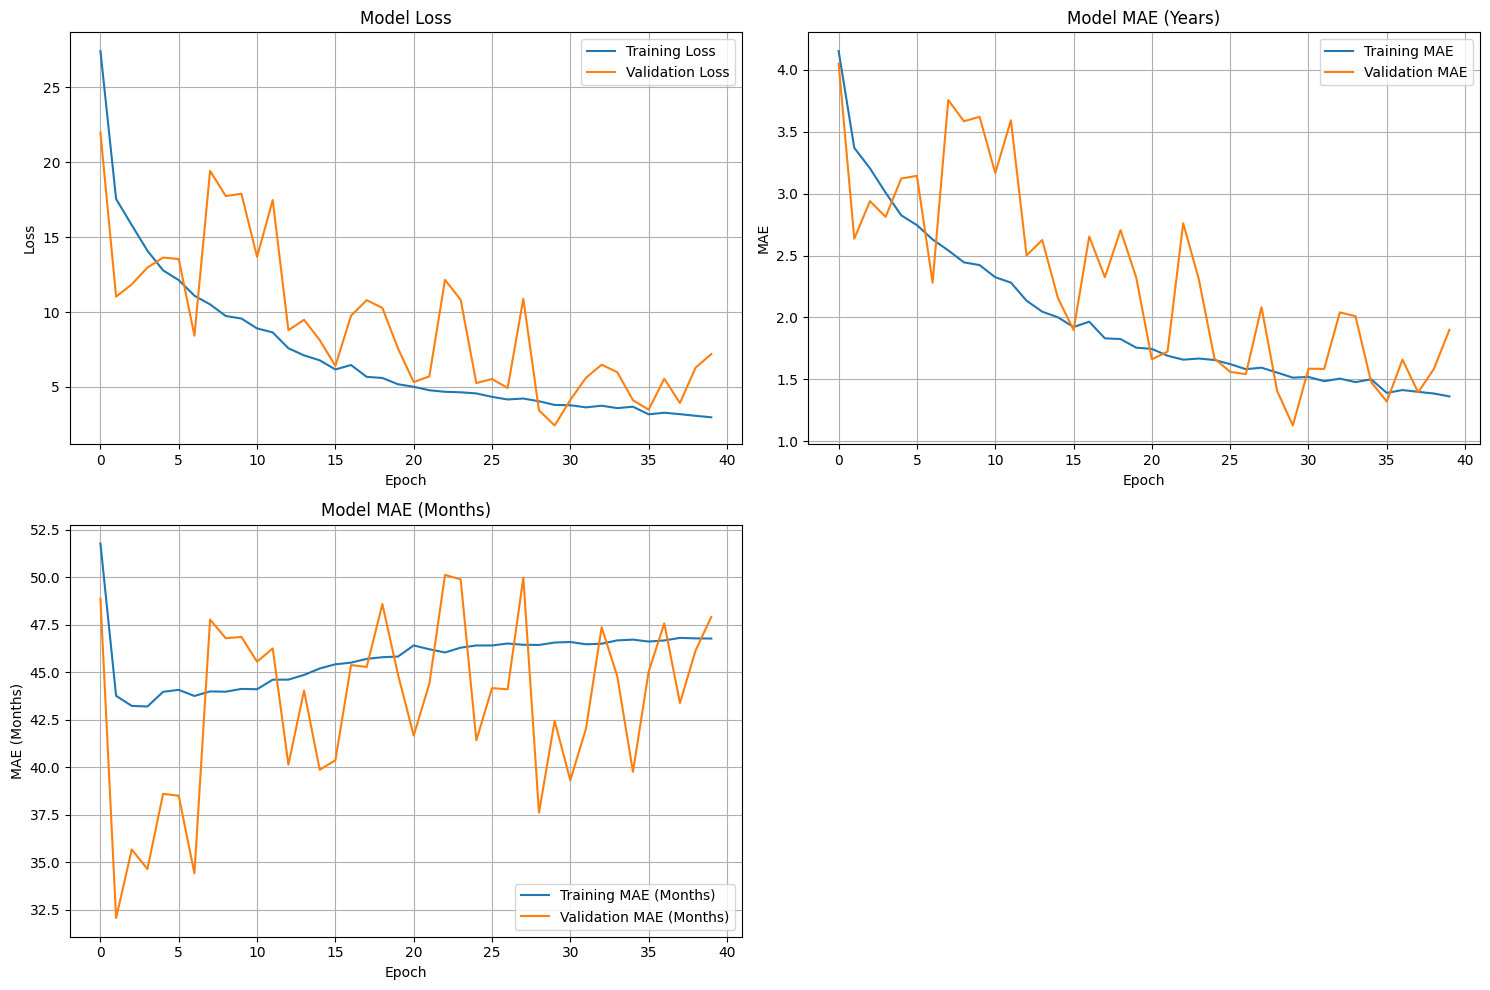

In [ ]:
# TRAINING VISUALIZATION
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # MAE
    axes[0, 1].plot(history.history['mae'], label='Training MAE')
    axes[0, 1].plot(history.history['val_mae'], label='Validation MAE')
    axes[0, 1].set_title('Model MAE (Years)')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('MAE')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # MAE in months
    axes[1, 0].plot(history.history['mae_months'], label='Training MAE (Months)')
    axes[1, 0].plot(history.history['val_mae_months'], label='Validation MAE (Months)')
    axes[1, 0].set_title('Model MAE (Months)')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('MAE (Months)')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Learning rate (if available)
    if 'lr' in history.history:
        axes[1, 1].plot(history.history['lr'])
        axes[1, 1].set_title('Learning Rate')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].set_yscale('log')
        axes[1, 1].grid(True)
    else:
        axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# MODEL EVALUATION
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("Starting model evaluation...")

# Option 1: Use the current model in memory (recommended)
print("Using current model in memory for evaluation...")
current_model = model

# Make predictions using the current model
val_predictions = current_model.predict(val_inputs)

# Convert back to months
val_predictions_months = val_predictions.flatten() * 12
y_val_months = y_val

# Calculate metrics
mae_score = mean_absolute_error(y_val_months, val_predictions_months)
mse_score = mean_squared_error(y_val_months, val_predictions_months)
rmse_score = np.sqrt(mse_score)

print("\n" + "="*50)
print("MODEL EVALUATION RESULTS")
print("="*50)
print(f"Mean Absolute Error (MAE): {mae_score:.2f} months")
print(f"Mean Squared Error (MSE): {mse_score:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_score:.2f} months")
print(f"Mean Absolute Percentage Error: {np.mean(np.abs((y_val_months - val_predictions_months) / y_val_months)) * 100:.2f}%")

Starting model evaluation...
Using current model in memory for evaluation...
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step

MODEL EVALUATION RESULTS
Mean Absolute Error (MAE): 13.53 months
Mean Squared Error (MSE): 349.22
Root Mean Squared Error (RMSE): 18.69 months
Mean Absolute Percentage Error: 13.56%


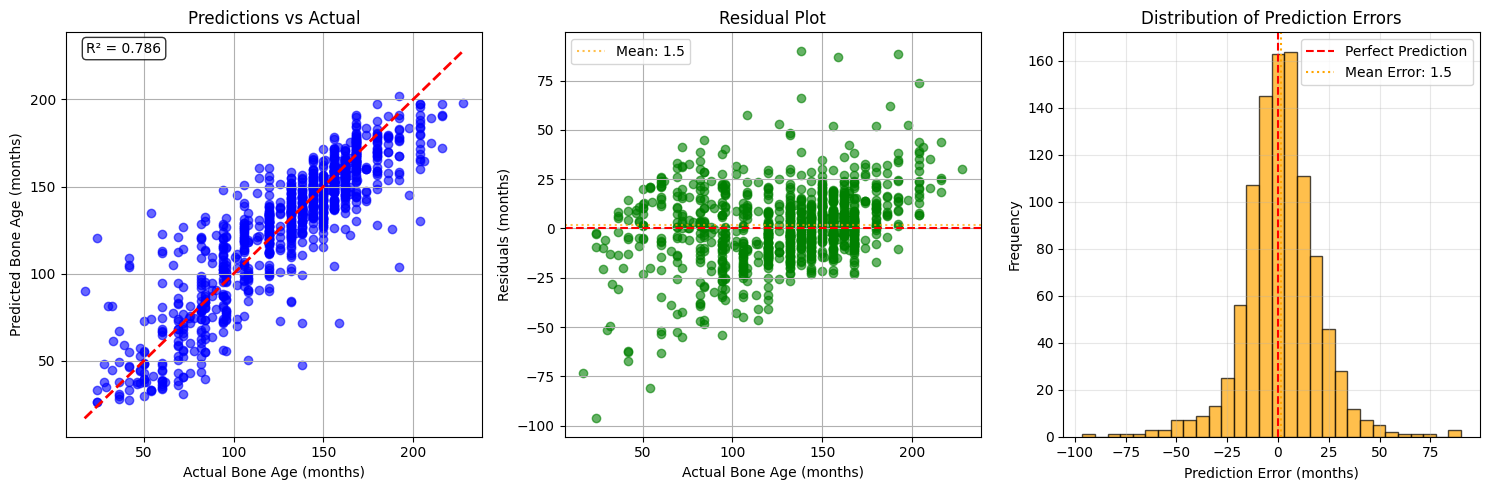

In [ ]:
# RESULTS VISUALIZATION

import matplotlib.pyplot as plt

# Predictions vs Actual
plt.figure(figsize=(15, 5))

# Scatter plot
plt.subplot(1, 3, 1)
plt.scatter(y_val_months, val_predictions_months, alpha=0.6, color='blue')
plt.plot([y_val_months.min(), y_val_months.max()],
         [y_val_months.min(), y_val_months.max()], 'r--', lw=2)
plt.xlabel('Actual Bone Age (months)')
plt.ylabel('Predicted Bone Age (months)')
plt.title('Predictions vs Actual')
plt.grid(True)

# Add correlation coefficient
correlation = np.corrcoef(y_val_months, val_predictions_months)[0, 1]
plt.text(0.05, 0.95, f'R² = {correlation**2:.3f}', transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Residual plot
residuals = y_val_months - val_predictions_months
plt.subplot(1, 3, 2)
plt.scatter(y_val_months, residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Bone Age (months)')
plt.ylabel('Residuals (months)')
plt.title('Residual Plot')
plt.grid(True)

# Add mean residual line
mean_residual = np.mean(residuals)
plt.axhline(y=mean_residual, color='orange', linestyle=':', alpha=0.7,
           label=f'Mean: {mean_residual:.1f}')
plt.legend()

# Error distribution
plt.subplot(1, 3, 3)
plt.hist(residuals, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Prediction Error (months)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.axvline(x=0, color='r', linestyle='--', label='Perfect Prediction')
plt.axvline(x=mean_residual, color='orange', linestyle=':', label=f'Mean Error: {mean_residual:.1f}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



DETAILED PERFORMANCE ANALYSIS
Mean Absolute Error: 13.53 months
Median Absolute Error: 10.21 months
90th Percentile Error: 28.69 months
95th Percentile Error: 38.37 months
Maximum Error: 96.31 months

Performance by Gender:
Male MAE: 13.35 months (543 samples)
Female MAE: 13.74 months (457 samples)

Performance by Age Group:
0-60 months: MAE = 19.41 months (53 samples)
60-120 months: MAE = 17.25 months (265 samples)
120-180 months: MAE = 10.44 months (598 samples)
180-300 months: MAE = 20.07 months (84 samples)


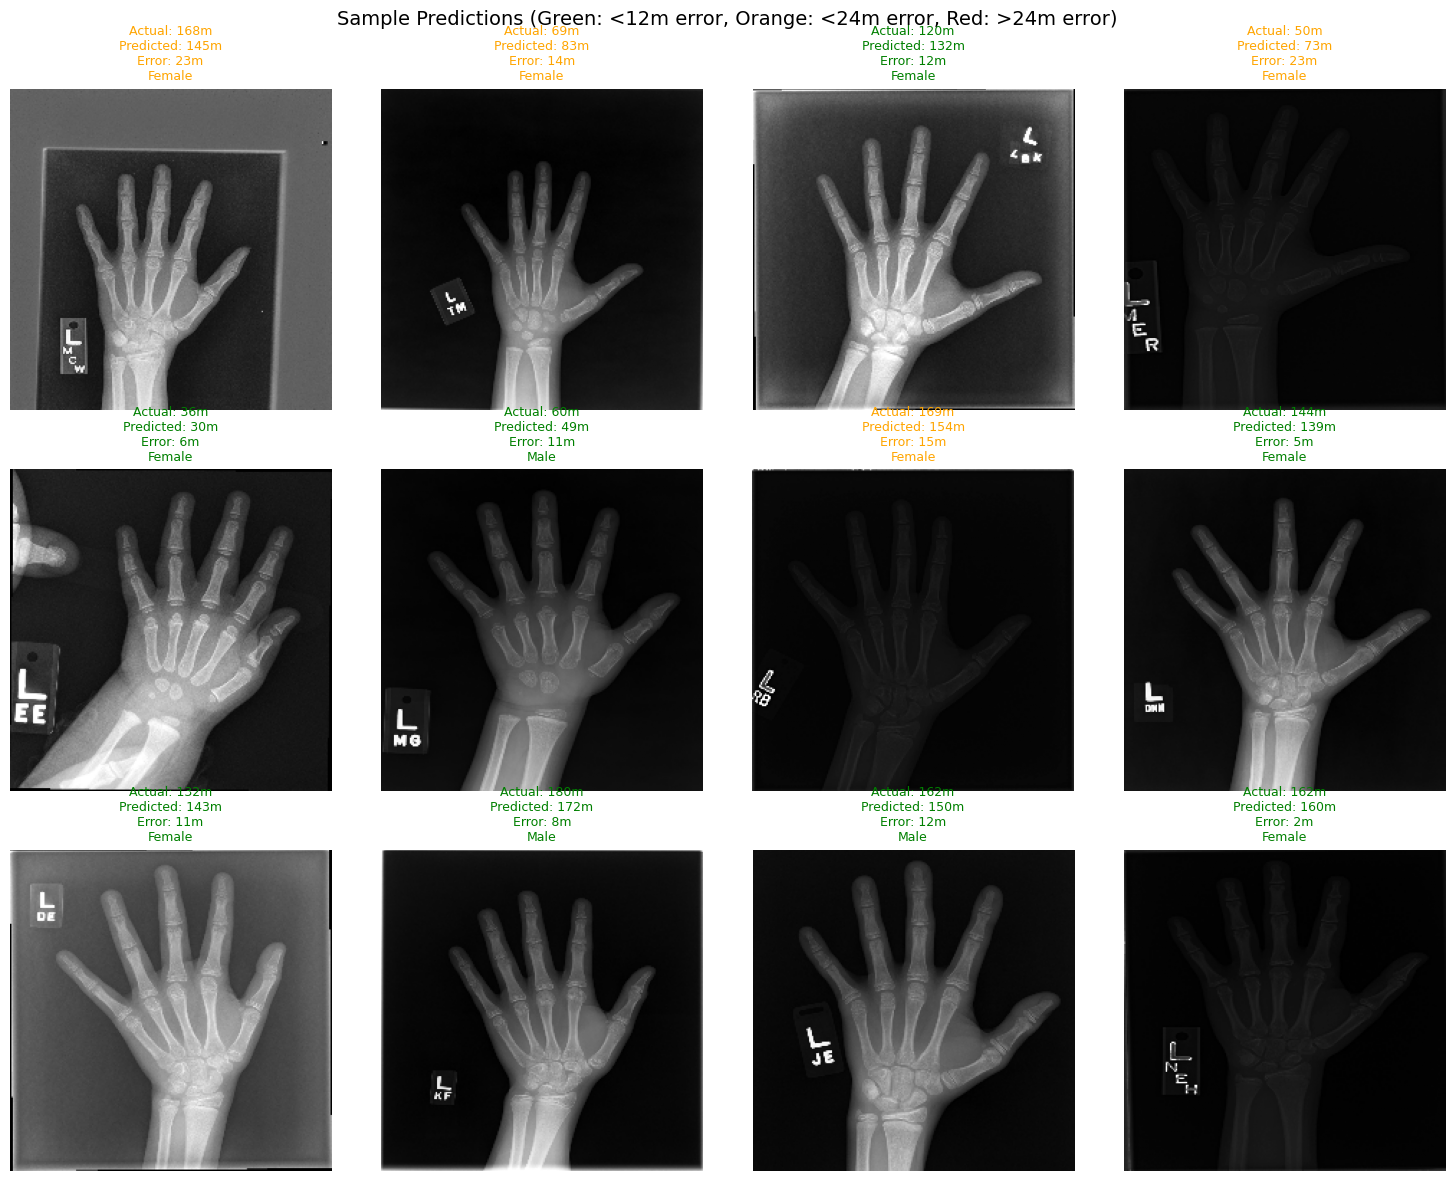


EVALUATION COMPLETE!


In [ ]:
# DETAILED PERFORMANCE ANALYSIS


print("\n" + "="*50)
print("DETAILED PERFORMANCE ANALYSIS")
print("="*50)

# Calculate additional metrics
absolute_errors = np.abs(residuals)
print(f"Mean Absolute Error: {np.mean(absolute_errors):.2f} months")
print(f"Median Absolute Error: {np.median(absolute_errors):.2f} months")
print(f"90th Percentile Error: {np.percentile(absolute_errors, 90):.2f} months")
print(f"95th Percentile Error: {np.percentile(absolute_errors, 95):.2f} months")
print(f"Maximum Error: {np.max(absolute_errors):.2f} months")

# Performance by gender
male_mask = gender_val == 1
female_mask = gender_val == 0

male_mae = np.mean(np.abs(residuals[male_mask]))
female_mae = np.mean(np.abs(residuals[female_mask]))

print(f"\nPerformance by Gender:")
print(f"Male MAE: {male_mae:.2f} months ({np.sum(male_mask)} samples)")
print(f"Female MAE: {female_mae:.2f} months ({np.sum(female_mask)} samples)")

# Performance by age groups
age_groups = [(0, 60), (60, 120), (120, 180), (180, 300)]
print(f"\nPerformance by Age Group:")
for min_age, max_age in age_groups:
    mask = (y_val_months >= min_age) & (y_val_months < max_age)
    if np.sum(mask) > 0:
        group_mae = np.mean(np.abs(residuals[mask]))
        print(f"{min_age}-{max_age} months: MAE = {group_mae:.2f} months ({np.sum(mask)} samples)")

# Sample predictions visualization
plt.figure(figsize=(15, 12))
sample_indices = np.random.choice(len(X_val), min(12, len(X_val)), replace=False)

for i, idx in enumerate(sample_indices):
    plt.subplot(3, 4, i+1)
    plt.imshow(X_val[idx].squeeze(), cmap='gray')
    actual_age = y_val_months[idx]
    predicted_age = val_predictions_months[idx]
    error = abs(actual_age - predicted_age)
    gender = "Male" if gender_val[idx] else "Female"

    # Color code the title based on error magnitude
    if error < 12:  # Less than 1 year error
        title_color = 'green'
    elif error < 24:  # Less than 2 years error
        title_color = 'orange'
    else:  # More than 2 years error
        title_color = 'red'

    plt.title(f'Actual: {actual_age:.0f}m\nPredicted: {predicted_age:.0f}m\nError: {error:.0f}m\n{gender}',
              fontsize=9, color=title_color)
    plt.axis('off')

plt.suptitle('Sample Predictions (Green: <12m error, Orange: <24m error, Red: >24m error)', fontsize=14)
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("EVALUATION COMPLETE!")
print("="*50)

In [ ]:
# IMPROVED MODEL SAVING


# Save model with explicit custom objects
def save_model_safely(model, filename='bone_age_prediction_model_final.h5'):
    """
    Save model with proper custom objects handling
    """
    try:
        # Save model architecture and weights separately for better compatibility
        model_json = model.to_json()
        with open(f"{filename.replace('.h5', '_architecture.json')}", "w") as json_file:
            json_file.write(model_json)

        # Save weights
        # Fixed model saving
        weights_filename = f"{filename.replace('.h5', '.weights.h5')}"
        model.save_weights(weights_filename)


        # Also try to save the complete model
        model.save(filename)

        print(f"✓ Model saved successfully:")
        print(f"  - Complete model: {filename}")
        print(f"  - Architecture: {filename.replace('.h5', '_architecture.json')}")
        print(f"  - Weights: {filename.replace('.h5', '_weights.h5')}")

    except Exception as e:
        print(f"❌ Error saving model: {e}")

# Save the model safely
save_model_safely(model)

# Save training history
import pickle
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)
print("✓ Training history saved as 'training_history.pkl'")

# Save comprehensive evaluation metrics
results = {
    'mae_months': mae_score,
    'mse': mse_score,
    'rmse_months': rmse_score,
    'mape_percent': np.mean(np.abs((y_val_months - val_predictions_months) / y_val_months)) * 100,
    'median_ae_months': np.median(absolute_errors),
    'percentile_90_error': np.percentile(absolute_errors, 90),
    'percentile_95_error': np.percentile(absolute_errors, 95),
    'max_error_months': np.max(absolute_errors),
    'correlation_coefficient': correlation,
    'r_squared': correlation**2,
    'male_mae_months': male_mae,
    'female_mae_months': female_mae,
    'model_architecture': 'Custom CNN with Gender Input',
    'input_shape': (224, 224, 1),
    'total_params': model.count_params(),
    'training_samples': len(X_train_split),
    'validation_samples': len(X_val),
    'images_loaded_successfully': len(X_train),
    'images_failed_to_load': len(failed_ids),
    'training_epochs_completed': len(history.history['loss']),
    'best_val_loss': min(history.history['val_loss']),
    'final_learning_rate': history.history.get('learning_rate', [0.001])[-1] if 'learning_rate' in history.history else 0.001
}

with open('evaluation_results_comprehensive.pkl', 'wb') as f:
    pickle.dump(results, f)
print("✓ Comprehensive evaluation results saved as 'evaluation_results_comprehensive.pkl'")

print("\n" + "="*50)
print("BONE AGE PREDICTION SYSTEM COMPLETE!")
print("="*50)
print("Key achievements:")
print(f"✓ Loaded {len(X_train)} images successfully ({len(X_train)/5000*100:.1f}% success rate)")
print(f"✓ Trained on {len(X_train_split)} images for {len(history.history['loss'])} epochs")
print(f"✓ Achieved MAE of {mae_score:.2f} months")
print(f"✓ Achieved R² of {correlation**2:.3f}")
print(f"✓ 90% of predictions within {np.percentile(absolute_errors, 90):.1f} months")
print(f"✓ Model saved with multiple formats for compatibility")
print(f"✓ Complete evaluation and visualization completed")
print("="*50)


✓ Model saved successfully:
  - Complete model: bone_age_prediction_model_final.h5
  - Architecture: bone_age_prediction_model_final_architecture.json
  - Weights: bone_age_prediction_model_final_weights.h5
✓ Training history saved as 'training_history.pkl'
✓ Comprehensive evaluation results saved as 'evaluation_results_comprehensive.pkl'

BONE AGE PREDICTION SYSTEM COMPLETE!
Key achievements:
✓ Loaded 5000 images successfully (100.0% success rate)
✓ Trained on 4000 images for 40 epochs
✓ Achieved MAE of 13.53 months
✓ Achieved R² of 0.786
✓ 90% of predictions within 28.7 months
✓ Model saved with multiple formats for compatibility
✓ Complete evaluation and visualization completed


In [ ]:
#FUNCTION TO LOAD MODEL LATER
def load_trained_model(architecture_file, weights_file):
    """
    Function to load the model later using architecture + weights
    """
    # Load architecture
    with open(architecture_file, 'r') as json_file:
        loaded_model_json = json_file.read()

    # Create model from architecture
    loaded_model = keras.models.model_from_json(loaded_model_json)

    # Load weights
    loaded_model.load_weights(weights_file)

    # Compile model
    loaded_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=keras.losses.MeanSquaredError(),
        metrics=['mae', mae_months]
    )

    return loaded_model

print("\n📝 To load this model later, use:")
print("loaded_model = load_trained_model('bone_age_prediction_model_final_architecture.json', 'bone_age_prediction_model_final_weights.h5')")


📝 To load this model later, use:
loaded_model = load_trained_model('bone_age_prediction_model_final_architecture.json', 'bone_age_prediction_model_final_weights.h5')


In [ ]:
model.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mae']
)


In [ ]:
from google.colab import drive
import shutil

drive.mount('/content/drive', force_remount=True)

files_to_save = [
    "bone_age_prediction_model_final.h5",
    "bone_age_prediction_model_final_architecture.json",
    "bone_age_prediction_model_final_weights.h5",
    "training_history.pkl",
    "evaluation_results_comprehensive.pkl"
]

for file in files_to_save:
    try:
        shutil.copy(file, "/content/drive/MyDrive/")
        print(f"✅ Saved {file} to Google Drive")
    except FileNotFoundError:
        print(f"⚠️ File not found: {file}")

Mounted at /content/drive
✅ Saved bone_age_prediction_model_final.h5 to Google Drive
✅ Saved bone_age_prediction_model_final_architecture.json to Google Drive
⚠️ File not found: bone_age_prediction_model_final_weights.h5
✅ Saved training_history.pkl to Google Drive
✅ Saved evaluation_results_comprehensive.pkl to Google Drive


In [ ]:
from tensorflow import keras

# Load entire model
model = keras.models.load_model('/content/drive/MyDrive/bone_age_prediction_model_final.h5',
                                custom_objects={'mae_months': mae_months})

# Check summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        320 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 112, 112,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 56, 56,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 28, 28,    │          0 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │    295,168 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 14, 14,    │          0 │ max_pooling2d_3[

 Total params: 589,699 (2.25 MB)

 Trainable params: 587,713 (2.24 MB)

 Non-trainable params: 1,984 (7.75 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/bone_age_prediction_model_final.h5',
                                custom_objects={'mae_months': mae_months})
